In [1]:
using Distributed
addprocs(3)

3-element Array{Int64,1}:
 2
 3
 4

In [2]:
using CSV
using DataFrames
using Distributions
using HTTP
import ForneyLab.dot2svg
@everywhere using Mamba
# using Mamba
using Plots

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/apple/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl


# 1 ベイズ推論の考え方
## 1.4 例題 : メッセージ数に変化はあるのか？
メッセージ受信数が時間が経つにつれて変化するかどうかを調べる

In [3]:
r = HTTP.request("GET", "https://git.io/vXTVC");
count_data = CSV.read(IOBuffer(r.body), header=["messages"])
disallowmissing!(count_data)

,messages
,Float64
1,13.0
2,24.0
3,8.0
4,24.0
5,7.0
6,35.0
7,14.0
8,11.0
9,15.0


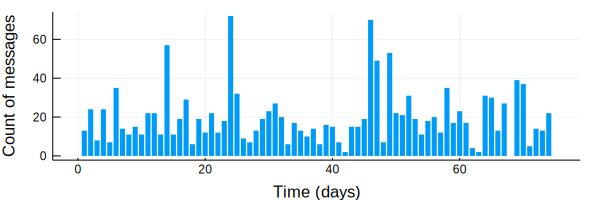

In [4]:
bar(count_data.messages, label = "", size = [600, 200],
    linecolor = :transparent,
    xlabel = "Time (days)", ylabel = "Count of messages")

$i$日目のメッセージを$C_i$とするとき、
\begin{align}
C_i \sim \text{Poisson}(\lambda)
\end{align}
とする.
### まずは一番な単純なモデル
\begin{align}
\lambda \sim \text{Exp}(\alpha)
\end{align}
のモデルを作ってみる。$\alpha$は計数データの平均の逆数とする。Distribution.jlにおけるパラメーターの取り方は、PyMCと異なることに留意。  
https://juliastats.github.io/Distributions.jl/latest/univariate.html#Continuous-Distributions-1

In [5]:
theta = mean(count_data.messages)

19.743243243243242

In [6]:
model0 = Model(
    
    obs = Stochastic(1,
        (ls, N) ->
            UnivariateDistribution[Poisson(ls[i]) for i in 1:N],
        false
    ),
    
    ls = Logical(1, (lambda, N) -> fill(lambda, N), false),
    
    lambda = Stochastic(theta -> Exponential(theta)),
)

Object of type "Model"
-------------------------------------------------------------------------------
lambda:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
obs:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
ls:
An unmonitored node of type "0-element ArrayLogical{1}"
Float64[]


In [7]:
data0 = Dict{Symbol, Any}(
    :obs => count_data.messages,
    :theta => theta,
    :N => length(count_data.messages),
)

Dict{Symbol,Any} with 3 entries:
  :N     => 74
  :obs   => [13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0,…
  :theta => 19.7432

In [8]:
inits0 = [
    Dict{Symbol, Any}(
        :obs => count_data.messages,
        :lambda => theta,
    ) for _ in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:lambda=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0])
 Dict(:lambda=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0])
 Dict(:lambda=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0])

In [9]:
scheme0 = [AMWG([:lambda], 1.0)]

1-element Array{Sampler{Mamba.AMWGTune},1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:lambda]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any


In [10]:
setsamplers!(model0, scheme0)
sim0 = mcmc(model0, data0, inits0, 40000, burnin = 10000, thin = 10, chains = 3)

MCMC Simulation of 40000 Iterations x 3 Chains...

      From worker 2:	Chain 1:   0% [5:47:47 of 5:47:53 remaining]
      From worker 3:	Chain 2:   0% [5:42:30 of 5:42:36 remaining]
      From worker 4:	Chain 3:   0% [5:45:52 of 5:45:57 remaining]
      From worker 2:	Chain 1:  10% [0:00:51 of 0:00:57 remaining]
      From worker 3:	Chain 2:  10% [0:00:50 of 0:00:56 remaining]
      From worker 4:	Chain 3:  10% [0:00:51 of 0:00:57 remaining]
      From worker 2:	Chain 1:  20% [0:00:25 of 0:00:31 remaining]
      From worker 3:	Chain 2:  20% [0:00:25 of 0:00:31 remaining]
      From worker 4:	Chain 3:  20% [0:00:25 of 0:00:31 remaining]
      From worker 2:	Chain 1:  30% [0:00:18 of 0:00:25 remaining]
      From worker 4:	Chain 3:  30% [0:00:18 of 0:00:25 remaining]
      From worker 3:	Chain 2:  30% [0:00:17 of 0:00:25 remaining]
      From worker 2:	Chain 1:  40% [0:00:13 of 0:00:21 remaining]
      From worker 4:	Chain 3:  40% [0:00:13 of 0:00:21 remaining]
      From worker 3:	Chai

Object of type "ModelChains"

Iterations = 10010:40000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 3000

[19.6897; 19.6523; … ; 19.4116; 19.0495]

[20.2556; 19.4528; … ; 19.2251; 19.411]

[19.5073; 19.906; … ; 20.1296; 19.397]

$\lambda$の平均はメッセージ数の平均とほぼ一致。

In [11]:
describe(sim0)

Iterations = 10010:40000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 3000

Empirical Posterior Estimates:
         Mean      SD       Naive SE       MCSE     ESS
lambda 19.7429 0.51659864 0.0054454278 0.008585909 3000

Quantiles:
         2.5%     25.0%     50.0%     75.0%     97.5%  
lambda 18.75212 19.390903 19.738329 20.083816 20.783087



In [12]:
gelmandiag(sim0, mpsrf = true, transform = true)

              PSRF 97.5%
      lambda 1.001 1.003
Multivariate 1.001   NaN



サンプリングの図示。サイズの変え方がわからない・・・

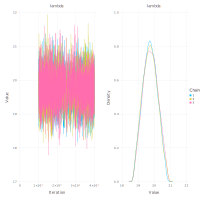

In [13]:
p0 = Mamba.plot(sim0, legend = true)
Mamba.draw(p0, nrow = 1, ncol = 2)

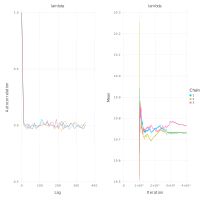

In [14]:
p0 = Mamba.plot(sim0, [:autocor, :mean], legend = true)
Mamba.draw(p0, nrow = 1, ncol = 2)

### 変化はあるか？
ここで、どこかで$\lambda$が大きくなっているか調べるために、
\begin{align}
\lambda = \left\{ \begin{array}{ll}
\lambda_1 & \text{if}\ t < \tau,\\
\lambda_2 & \text{if}\ t \ge \tau. 
\end{array} \right.
\end{align}
となっていると仮定する。
事前分布は、
\begin{align}
\lambda_1 & \sim \text{Exp}(\alpha) \\
\lambda_2 & \sim \text{Exp}(\alpha) \\
\tau & \sim \text{DiscreteUniform}(1,N)
\end{align}
とする。

In [15]:
model1 = Model(
    
    obs = Stochastic(1,
        (lambda, N) ->
            UnivariateDistribution[Poisson(lambda[i]) for i in 1:N],
        false
    ),
    
    lambda = Logical(1, 
        (lambda1, lambda2, tau, N) -> 
            (out = fill(lambda1, N);
            i = Int64(tau.value);
            out[i:end, :] .= lambda2;
            out),
        false),
    
    lambda1 = Stochastic(theta -> Exponential(theta)),
    lambda2 = Stochastic(theta -> Exponential(theta)),
    
    tau = Stochastic(N -> DiscreteUniform(1, N)),
)

Object of type "Model"
-------------------------------------------------------------------------------
lambda:
An unmonitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
lambda1:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
obs:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
tau:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
lambda2:
A monitored node of type "ScalarStochastic"
NaN


In [16]:
inits1 = [
    Dict{Symbol, Any}(
        :obs => count_data.messages,
        :lambda1 => theta,
        :lambda2 => theta,
        :tau => 1,
    ) for _ in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:lambda1=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0],:tau=>1,:lambda2=>19.7432)
 Dict(:lambda1=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0],:tau=>1,:lambda2=>19.7432)
 Dict(:lambda1=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0],:tau=>1,:lambda2=>19.7432)

In [17]:
scheme1 = [AMWG([:lambda1, :lambda2], 1.0), DGS(:tau)]

2-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:lambda1, :lambda2]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.DSTune{Function}}"
Sampling Block Nodes:
Symbol[:tau]

CodeInfo(
1 ─ %1 = π (##238#241(Box(Symbol[:tau])), Const(##238#241(Box(Symbol[:tau])), false))
│   %2 = (%1)(model, block)::Const(nothing, false)
└──      return %2
) => Nothing
                                                                                                                                                                                       

In [18]:
setsamplers!(model1, scheme1)
sim1 = mcmc(model1, data0, inits1, 40000, burnin = 10000, thin = 10, chains = 3)

MCMC Simulation of 40000 Iterations x 3 Chains...

      From worker 3:	Chain 2:   0% [1:27:34 of 1:27:35 remaining]
      From worker 2:	Chain 1:   0% [1:28:49 of 1:28:51 remaining]
      From worker 4:	Chain 3:   0% [1:30:26 of 1:30:27 remaining]
      From worker 3:	Chain 2:  10% [0:01:53 of 0:02:05 remaining]
      From worker 2:	Chain 1:  10% [0:01:57 of 0:02:10 remaining]
      From worker 4:	Chain 3:  10% [0:01:58 of 0:02:11 remaining]
      From worker 3:	Chain 2:  20% [0:01:43 of 0:02:09 remaining]
      From worker 2:	Chain 1:  20% [0:01:44 of 0:02:10 remaining]
      From worker 4:	Chain 3:  20% [0:01:45 of 0:02:11 remaining]
      From worker 3:	Chain 2:  30% [0:01:27 of 0:02:05 remaining]
      From worker 2:	Chain 1:  30% [0:01:28 of 0:02:05 remaining]
      From worker 4:	Chain 3:  30% [0:01:28 of 0:02:06 remaining]
      From worker 3:	Chain 2:  40% [0:01:15 of 0:02:05 remaining]
      From worker 2:	Chain 1:  40% [0:01:16 of 0:02:06 remaining]
      From worker 4:	Chai

Object of type "ModelChains"

Iterations = 10010:40000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 3000

[46.0 24.476 17.7986; 45.0 24.9369 16.5481; … ; 44.0 22.325 17.4299; 46.0 22.325 18.1492]

[46.0 23.015 18.1635; 45.0 20.601 18.1635; … ; 45.0 23.1086 17.0654; 44.0 22.6173 17.0546]

[44.0 22.9099 18.6028; 45.0 22.9099 17.3928; … ; 45.0 23.9054 17.2116; 45.0 21.4702 17.971]

In [19]:
describe(sim1)

Iterations = 10010:40000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 3000

Empirical Posterior Estimates:
           Mean       SD       Naive SE       MCSE     ESS
    tau 45.218889 2.07881137 0.0219125958 0.021605615 3000
lambda2 22.695842 0.91353038 0.0096294557 0.012537474 3000
lambda1 17.755103 0.62965246 0.0066371197 0.010544805 3000

Quantiles:
           2.5%     25.0%     50.0%     75.0%    97.5% 
    tau 43.000000 45.000000 45.000000 46.000000 46.0000
lambda2 20.936332 22.087217 22.696983 23.306215 24.4943
lambda1 16.534951 17.344957 17.754399 18.172314 19.0331



In [20]:
gelmandiag(sim1, mpsrf = true, transform = true)

              PSRF 97.5%
         tau 1.002 1.002
     lambda2 1.001 1.004
     lambda1 1.001 1.002
Multivariate 1.002   NaN



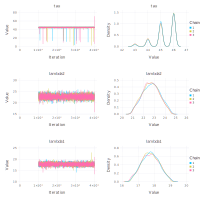

In [21]:
p1 = Mamba.plot(sim1, legend = true)
Mamba.draw(p1[:, 1:3], nrow = 3, ncol = 2)

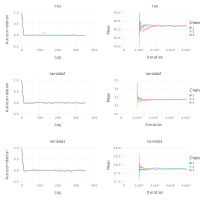

In [22]:
p1 = Mamba.plot(sim1, [:autocor, :mean], legend = true)
Mamba.draw(p1[:, 1:3], nrow = 3, ncol = 2)